In [1]:
using GpABC, DifferentialEquations, Distances, Plots

# Rejection ABC using GaussProABC - estimating parameters

This notebook demonstrates how to perform simulation- and emulation-based rejection ABC using GaussProABC for parameter estimation of an ODE model.

Start by choosing some settings for ABC, the emulator and the toy, noise-free ODE system. There is also a wrapper function that returns the solution to the toy system for some given parameters and ODE solution options.

In [2]:
#
# ABC settings
#
n_var_params = 2
n_particles = 1000
threshold = 0.5
priors = [Distributions.Uniform(0., 5.), Distributions.Uniform(0., 5.)]
distance_metric = euclidean
progress_every = 1000

#
# Emulation settings
#
n_design_points = 100
batch_size = 1000
max_iter = 1000

#
# True parameters
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by DifferentialEquations
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]./(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

(::#1) (generic function with 1 method)

## Plot reference data

The reference data is the concentrations over time for the three species. Computed by solving the model with the true parameters.

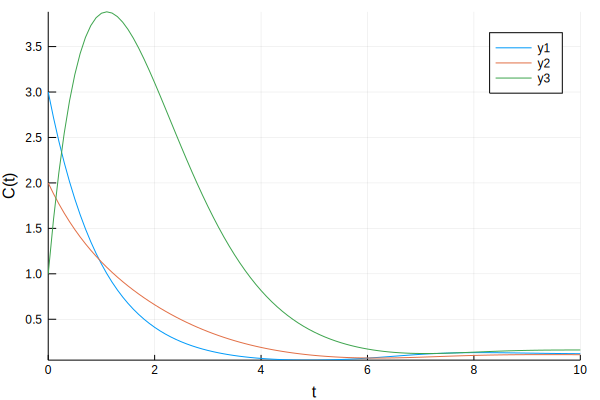

In [3]:
#
# Get reference data and plot it
#
reference_data = GeneReg(true_params, Tspan, x0, solver, saveat)
println("Got reference data")

plot(reference_data.t, transpose(hcat(reference_data.u...)), xlabel="t", ylabel="C(t)")


## Simulation-based rejection ABC

To perform rejection ABC, first construct an instance of one of either two objects: `SimulatedABCRejectionInput` or `EmulatedABCRejectionInput`.

The simulated version contains the number of accepted particles, acceptance threshold, priors, the distance metric and the simulator funciton. Note that this needs to be extended to include summary statistics.

The simulator function is user-defined and must to take the unknown parameters as a single argument and return the simluated trajectories.

After constructing the input object it is passed to `ABCrejection` with the reference (observed) data to perform rejection ABC.

In [4]:
#
# Simulation
#
simulator_function(var_params) = GeneReg(vcat(var_params, true_params[n_var_params+1:end]), Tspan, x0, solver, saveat)

sim_rej_input = SimulatedABCRejectionInput(n_var_params,
                        n_particles,
                        threshold,
                        priors,
                        "keep_all",
                        distance_metric,
                        simulator_function)

sim_result = ABCrejection(sim_rej_input, reference_data, progress_every=progress_every)

2018-06-24T22:48:12.723 Accepted 35/1000 particles.
2018-06-24T22:48:12.882 Accepted 57/2000 particles.
2018-06-24T22:48:13.034 Accepted 80/3000 particles.
2018-06-24T22:48:13.185 Accepted 99/4000 particles.
2018-06-24T22:48:13.337 Accepted 121/5000 particles.
2018-06-24T22:48:13.487 Accepted 139/6000 particles.
2018-06-24T22:48:13.64 Accepted 162/7000 particles.
2018-06-24T22:48:13.79 Accepted 188/8000 particles.
2018-06-24T22:48:13.94 Accepted 213/9000 particles.
2018-06-24T22:48:14.091 Accepted 238/10000 particles.
2018-06-24T22:48:14.241 Accepted 258/11000 particles.
2018-06-24T22:48:14.384 Accepted 289/12000 particles.
2018-06-24T22:48:14.533 Accepted 317/13000 particles.
2018-06-24T22:48:14.681 Accepted 338/14000 particles.
2018-06-24T22:48:14.83 Accepted 364/15000 particles.
2018-06-24T22:48:14.983 Accepted 392/16000 particles.
2018-06-24T22:48:15.329 Accepted 414/17000 particles.
2018-06-24T22:48:15.592 Accepted 438/18000 particles.
2018-06-24T22:48:15.749 Accepted 456/19000 pa

GpABC.ABCRejectionOutput(2, 1000, 41676, 0.5, [1.70748 1.09689; 1.45464 1.09503; … ; 1.98677 0.968355; 2.17154 1.04252], [0.321151, 0.353717, 0.124601, 0.360767, 0.326755, 0.419523, 0.224094, 0.492959, 0.328665, 0.0848942  …  0.460879, 0.332269, 0.334473, 0.408212, 0.34398, 0.482813, 0.450096, 0.415101, 0.108515, 0.169962], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

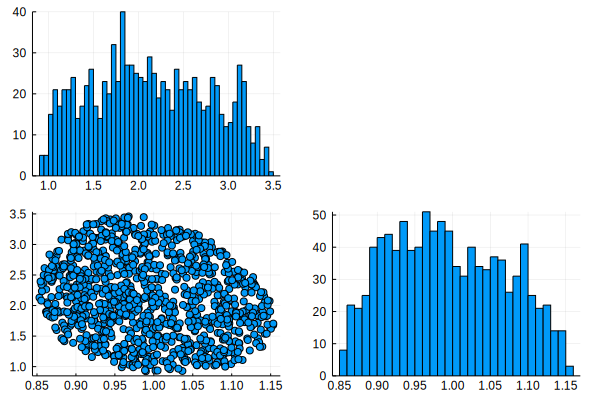

In [5]:
plot(sim_result)

## Emulation-based Rejection ABC

First train the emulator. This requires training inputs `X` and training outputs `y`, where `X` is an array with size (n_design_points, n_unknown_parameters) and `y` is an array with size (n_design_points).

The function `get_training_data` returns `X` and `y` in the correct format to be used with a `GPModel`.

Then train the model, plotting the design points and their distances.

Trained emulator


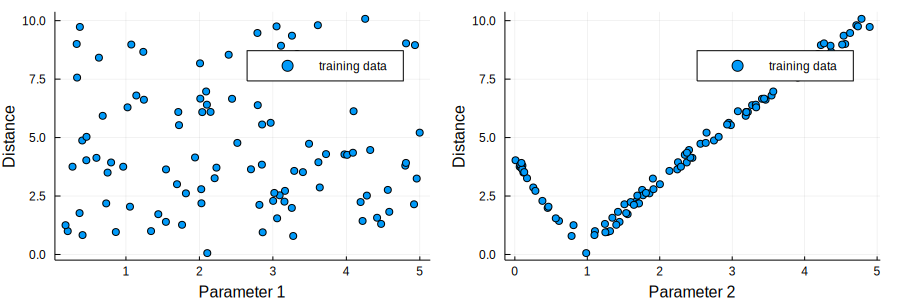

In [6]:
#
# Train the Emulator
#

#
# First prepare data for emulator - matrix X contains design ponts and y contains distances
#
function get_training_data(n_design_points,
  priors,
  simulator_function, distance_metric,
  reference_data)
    
  X = zeros(n_design_points, length(priors))
  y = zeros(n_design_points)  
  for i in 1:n_design_points
    dp = [rand(d) for d in priors]
    X[i,:] = dp
    y[i] = distance_metric(simulator_function(dp), reference_data)
  end
    
  return X, y
end

X, y = get_training_data(n_design_points, priors, simulator_function, distance_metric, reference_data)

#
# Train emulator - VARIANCE SEEMS SMALL
#
gpem = GPModel(training_x=X, training_y=y, kernel=SquaredExponentialArdKernel())
gp_train(gpem)

println("Trained emulator")

#
# Plot design points
#
plts = [scatter(X[:,idx], y, label="training data", xlabel="Parameter $idx", ylabel="Distance") for idx = 1:size(priors, 1)]
plot(plts..., size=(900, 300))

The second parameter is easier to pick up using this distance metric and summary statistic than the first.

When creating an `EmulatedABCRejectionInput` object provide a function that returns the emulated distances rather than the `simulator_function` required in the simulation case. Also provide a batch size and a maximum number of iterations.

In [7]:
#
# Use the emulator for rejection ABC
#
function predict_distance(p::AbstractArray{Float64})
    result = gp_regression(p,gpem)[1]
    return result
end

emu_rej_input = EmulatedABCRejectionInput(n_var_params,  
  n_particles,
  threshold,
  priors,
  predict_distance,
  batch_size,
  max_iter)

emu_result = ABCrejection(emu_rej_input, reference_data, progress_every=5)

2018-06-24T22:48:40.908 Accepted 59/5000 particles (5 batches of size 1000).
2018-06-24T22:48:40.986 Accepted 114/10000 particles (10 batches of size 1000).
2018-06-24T22:48:41.057 Accepted 192/15000 particles (15 batches of size 1000).
2018-06-24T22:48:41.119 Accepted 249/20000 particles (20 batches of size 1000).
2018-06-24T22:48:41.188 Accepted 305/25000 particles (25 batches of size 1000).
2018-06-24T22:48:41.26 Accepted 355/30000 particles (30 batches of size 1000).
2018-06-24T22:48:41.325 Accepted 405/35000 particles (35 batches of size 1000).
2018-06-24T22:48:41.394 Accepted 461/40000 particles (40 batches of size 1000).
2018-06-24T22:48:41.467 Accepted 513/45000 particles (45 batches of size 1000).
2018-06-24T22:48:41.529 Accepted 563/50000 particles (50 batches of size 1000).
2018-06-24T22:48:41.602 Accepted 609/55000 particles (55 batches of size 1000).
2018-06-24T22:48:41.676 Accepted 676/60000 particles (60 batches of size 1000).
2018-06-24T22:48:41.741 Accepted 729/65000 p

GpABC.ABCRejectionOutput(2, 1000, 93000, 0.5, [2.12764 1.0274; 2.17616 1.01637; … ; 2.58579 0.989651; 2.15205 0.911375], [0.440417, 0.435202, 0.471357, 0.432883, 0.441013, 0.455281, 0.438846, 0.438509, 0.494733, 0.470911  …  0.481448, 0.450103, 0.47059, 0.49231, 0.49065, 0.442565, 0.445447, 0.432668, 0.446547, 0.454177], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

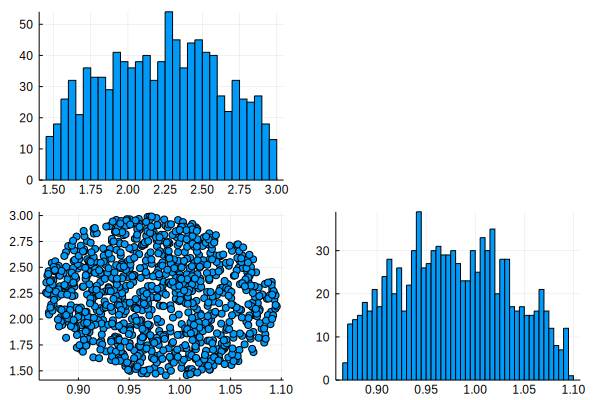

In [14]:
plot(emu_result)

# Comparing the resulting posteriors from simulation and emulation

They are similar and both center on the correct parameter values.

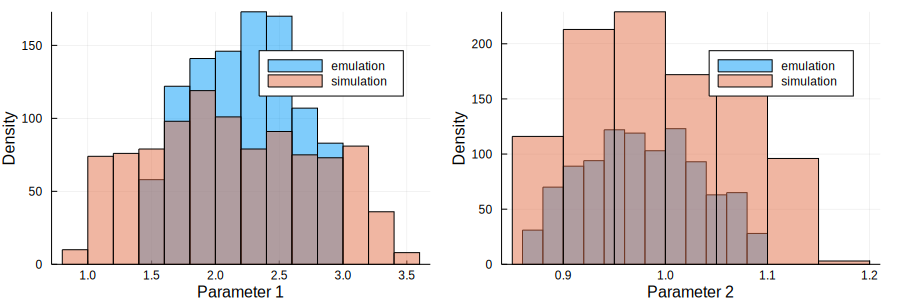

In [8]:
plts = Vector{Plots.Plot}(n_var_params)
for idx in 1:n_var_params
    plts[idx] = histogram([emu_result.population[:,idx] sim_result.population[:,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(900,300))

# ABC-SMC

In [9]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0]

3-element Array{Float64,1}:
 3.0
 2.0
 1.0

## Simulation-based ABC-SMC

In [18]:
sim_abcsmc_input = SimulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    "keep_all",
    distance_metric,
    simulator_function)

sim_abcsmc_res = ABCSMC(sim_abcsmc_input, reference_data)

2018-06-24T22:50:32.002 Accepted 344/1000 particles.
2018-06-24T22:50:32.161 Accepted 673/2000 particles.
2018-06-24T22:50:33.045 Accepted 413/1000 particles.
2018-06-24T22:50:33.684 Accepted 825/2000 particles.
2018-06-24T22:50:34.598 Accepted 196/1000 particles.
2018-06-24T22:50:35.236 Accepted 387/2000 particles.
2018-06-24T22:50:35.884 Accepted 561/3000 particles.
2018-06-24T22:50:36.519 Accepted 766/4000 particles.
2018-06-24T22:50:37.163 Accepted 976/5000 particles.


GpABC.ABCSMCOutput(2, [1000, 1000, 1000], [2962, 2425, 5122], [3.0, 2.0, 1.0], Array{Float64,2}[[2.71103 1.12523; 1.97468 1.68159; … ; 0.544476 1.5101; 4.19784 1.76968], [4.98642 0.974528; 1.36899 1.50378; … ; 3.82066 0.624719; 4.96637 0.848725], [3.70776 1.06944; 4.19774 0.907406; … ; 3.28608 0.913336; 3.91815 0.826874]], Array{Float64,1}[[0.543576, 2.12583, 2.64208, 1.24948, 0.825893, 1.96768, 2.35368, 0.999138, 2.74295, 0.939561  …  2.78393, 2.57875, 0.52528, 2.45361, 1.66203, 1.04349, 1.22283, 2.19717, 1.655, 2.72585], [0.937374, 1.56595, 1.08373, 1.90276, 1.58534, 1.28632, 1.07459, 0.404558, 1.08588, 0.633611  …  1.315, 0.799265, 0.855228, 1.05602, 1.76545, 1.72787, 1.71619, 0.576764, 1.3536, 0.951073], [0.688835, 0.719827, 0.727521, 0.591794, 0.601904, 0.547279, 0.931706, 0.417787, 0.957969, 0.820026  …  0.479324, 0.777161, 0.978493, 0.897167, 0.741052, 0.384099, 0.824348, 0.479214, 0.480657, 0.769764]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0

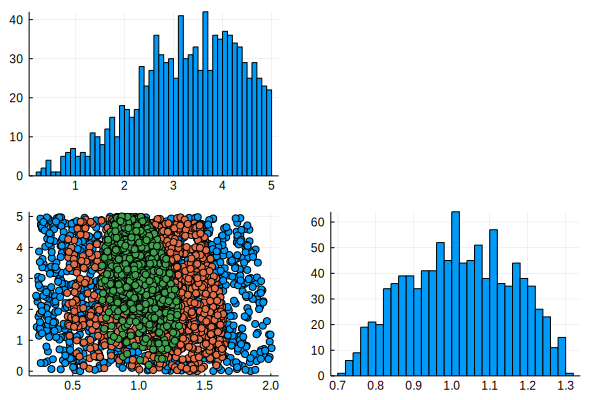

In [19]:
plot(sim_abcsmc_res)

## Emulation-based ABC-SMC

In [11]:
emu_abcsmc_input = EmulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    predict_distance,
    batch_size,
    max_iter)

emu_abcsmc_res = ABCSMC(emu_abcsmc_input, reference_data)

2018-06-24T22:48:47.802 Accepted 602/1000 particles.
2018-06-24T22:48:48.916 Accepted 415/1000 particles.
2018-06-24T22:48:49.558 Accepted 836/2000 particles.


GpABC.ABCSMCOutput(2, [1000, 1000, 1000], [3000, 1626, 2403], [3.0, 2.0, 1.0], Array{Float64,2}[[0.393351 1.54676; 4.33872 0.612409; … ; 1.07845 1.88113; 3.23585 0.834285], [3.47416 0.626363; 1.01276 0.896397; … ; 2.69475 1.06393; 3.467 0.922886], [2.30624 1.00497; 3.48238 1.08355; … ; 2.53292 0.972207; 2.48713 0.964826]], Array{Float64,1}[[1.79862, 1.49941, 1.67377, 2.84166, 2.79686, 0.849909, 0.623375, 0.585076, 1.4541, 2.83227  …  2.27139, 2.84395, 0.559639, 2.82559, 1.08361, 0.949071, 1.23059, 2.21312, 2.68548, 0.643785], [1.22666, 0.666766, 0.74276, 0.663623, 1.60767, 0.968349, 1.48788, 0.64457, 1.78205, 0.994185  …  1.79132, 0.665036, 1.84312, 0.807603, 1.79169, 0.616222, 1.62613, 0.828615, 0.501708, 0.613202], [0.433169, 0.684201, 0.987208, 0.571039, 0.782987, 0.838921, 0.661249, 0.974113, 0.440878, 0.935746  …  0.668443, 0.536938, 0.813537, 0.73387, 0.76004, 0.633602, 0.64754, 0.858914, 0.440663, 0.437868]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.

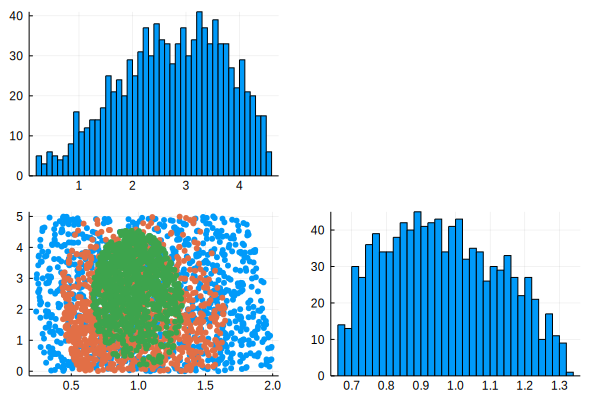

In [27]:
plot(emu_abcsmc_res, markerstrokecolor=false)

## Compare the posteriors

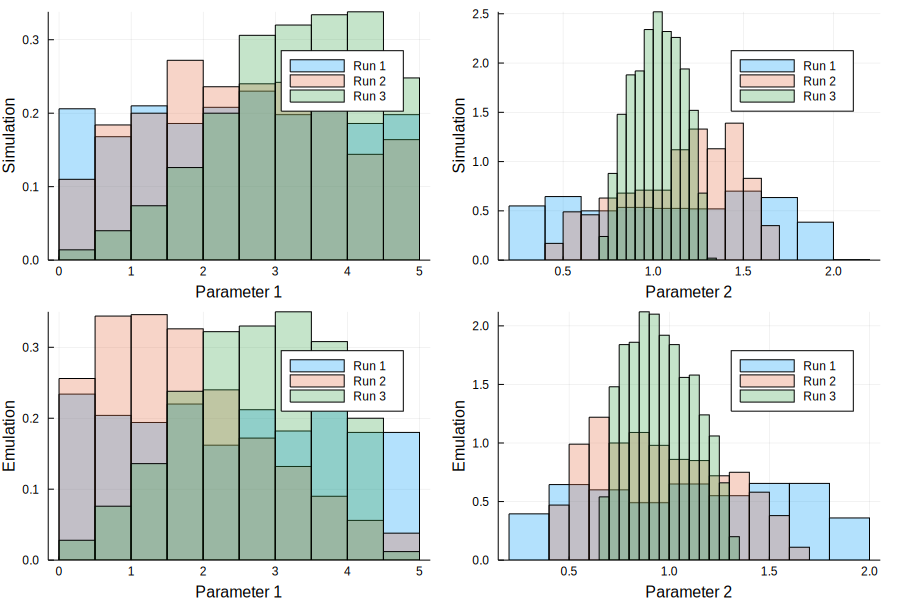

In [21]:
abcsmc_res = [sim_abcsmc_res, emu_abcsmc_res]
ylabels=["Simulation", "Emulation"]
plts = Vector{Plots.Plot}(n_var_params * 2)
idx = 1
for i in 1:2
    for j in 1:n_var_params
        hist_data = hcat([abcsmc_res[i].population[k][:,j] for k in 1:length(threshold_schedule)]...)
        labels = ["Run $k" for k in 1:length(threshold_schedule)]
        plts[idx] = histogram(hist_data, label=labels, fillalpha=0.3, 
            xlabel="Parameter $j", ylabel=ylabels[i], normed=true)
        idx += 1
    end
end
plot(plts..., size=(900,600))


In [13]:
size(abcsmc_res[1].population[end])

LoadError: [91mUndefVarError: abcsmc_res not defined[39m